In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [2]:
!du -sh /home/roman/mne_data


60G	/home/roman/mne_data


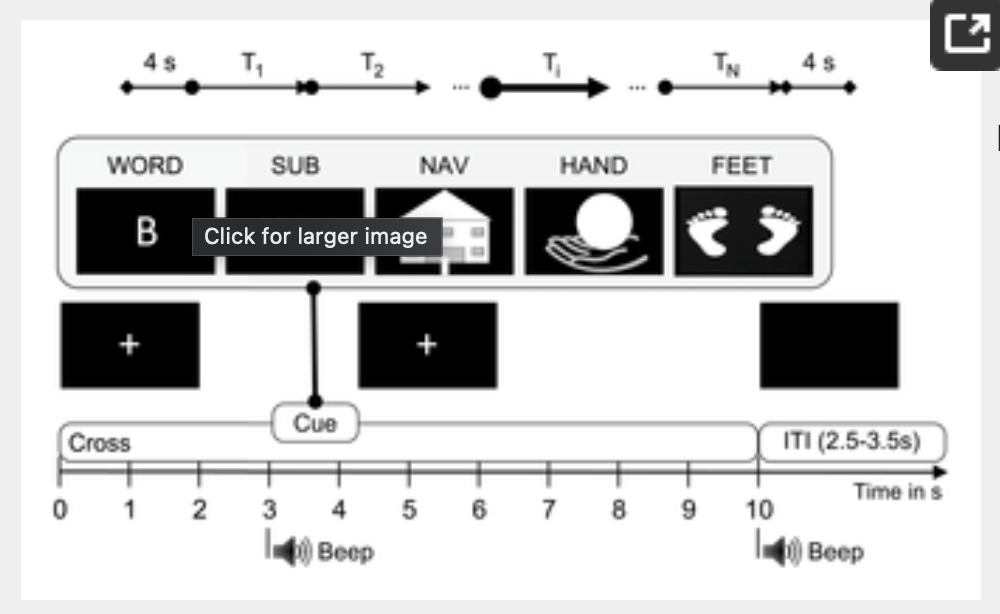

From 3 to 10 s one of 5 tasks (2 of which were MI: hand/feet)

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0123727

In [9]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [10]:
%%time

ds = BNCI2015004()

print(f'N_subj: {len(ds.subject_list)}')


ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
eventsOI  = ['right_hand', 'feet']


subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(ch_names)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



N_subj: 9


  0%|                                                                                                                                   | 0/9 [00:00<?, ?it/s]

['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 11%|█████████████▋                                                                                                             | 1/9 [00:34<04:39, 34.94s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 22%|███████████████████████████▎                                                                                               | 2/9 [01:09<04:03, 34.76s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 33%|█████████████████████████████████████████                                                                                  | 3/9 [01:44<03:28, 34.80s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 44%|██████████████████████████████████████████████████████▋                                                                    | 4/9 [02:18<02:52, 34.52s/it]

(150, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 56%|████████████████████████████████████████████████████████████████████▎                                                      | 5/9 [02:53<02:18, 34.53s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 6/9 [03:27<01:43, 34.56s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                           | 7/9 [04:01<01:08, 34.43s/it]

(150, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8/9 [04:36<00:34, 34.54s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
['right_hand', 'feet', 'navigation', 'subtraction', 'word_ass']
['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2', 'stim']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:11<00:00, 34.59s/it]

(160, 7, 420), ['feet' 'navigation' 'right_hand' 'subtraction' 'word_ass']
CPU times: user 4min 45s, sys: 26.2 s, total: 5min 11s
Wall time: 5min 11s


In [12]:
meta

subject    session    run       label
0           1  session_0  run_0  right_hand
1           1  session_0  run_0  right_hand
2           1  session_0  run_0  right_hand
3           1  session_0  run_0        feet
4           1  session_0  run_0  right_hand
...       ...        ...    ...         ...
1415        9  session_1  run_0        feet
1416        9  session_1  run_0        feet
1417        9  session_1  run_0        feet
1418        9  session_1  run_0  right_hand
1419        9  session_1  run_0  right_hand

[1420 rows x 4 columns]

In [13]:
labelsToIDs = {"right_hand": 0, "feet": 1}

def save_to_torch(samples, meta, ds):    
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

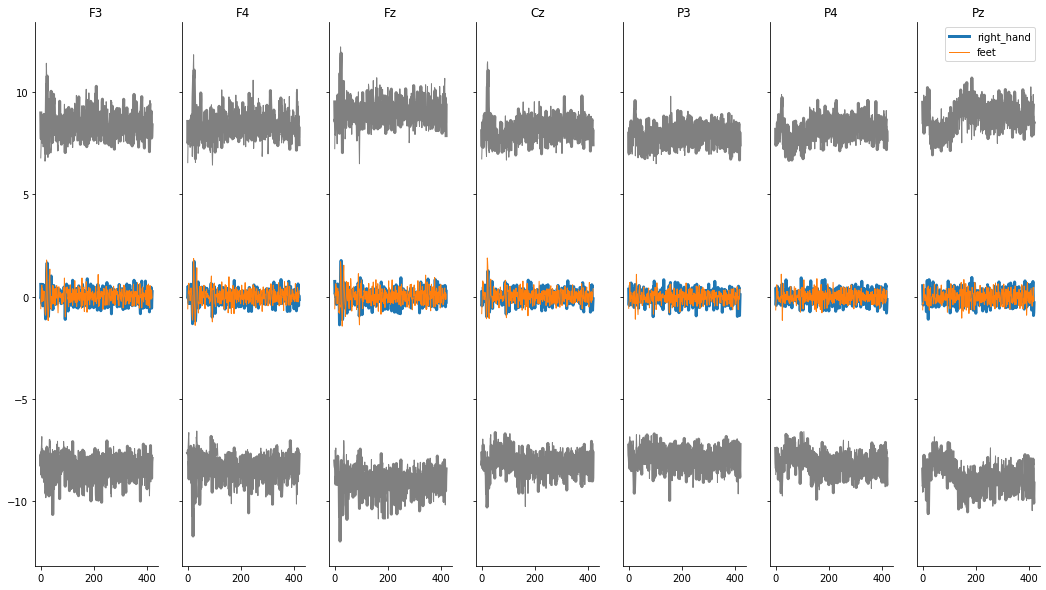

In [15]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
feet = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[feet,i,:].mean(0).squeeze()
    s = samples[feet,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='feet'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()